# Import

In [1]:
from importlib import reload

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import cv2
import pickle
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
import pandas as pd
import sys
sys.path.insert(0, './atarihead')

import scipy
import FUNCTIONS as func
reload(func)

import h5py

pd.options.display.float_format = '{:.3g}'.format

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

torch.set_default_dtype(torch.float32)

# Load Replay buffers

In [2]:
games=['Alien',
       'Asterix',
       'BankHeist',
       'Berzerk',
       'Breakout',
       'Centipede',
       'DemonAttack',
       'Enduro',
       'Freeway',
       'Frostbite',
       'Hero',
       'MontezumaRevenge',
       'MsPacman',
       'NameThisGame',
       'Phoenix',
       'Riverraid',
       'RoadRunner',
       'Seaquest',
       'SpaceInvaders',
       'Venture']

AA_to_AH={'Alien': 'alien',
       'Asterix': 'asterix',
       'BankHeist': 'bank_heist',
       'Berzerk': 'berzerk',
       'Breakout': 'breakout',
       'Centipede': 'centipede',
       'DemonAttack': 'demon_attack',
       'Enduro': 'enduro',
       'Freeway': 'freeway',
       'Frostbite': 'frostbite',
       'Hero': 'hero',
       'MontezumaRevenge': 'montezuma_revenge',
       'MsPacman': 'ms_pacman',
       'NameThisGame': 'name_this_game',
       'Phoenix': 'phoenix',
       'Riverraid': 'riverraid',
       'RoadRunner': 'road_runner',
       'Seaquest': 'seaquest',
       'SpaceInvaders': 'space_invaders',
       'Venture': 'venture'}

In [3]:
### Make game max reward!!!

game_name='Alien' # Give name in AA style

memoryAA = func.HDF5ReplayBufferRAM.load(
file_path=fr'replay_buffers/atari_agents/{game_name}_atari_agents_buffer_100k_4f.h5',file_rw_option='r', train_val_split=0.8)
memoryAH = func.HDF5ReplayBufferRAM.load(
file_path=fr'replay_buffers/atarihead/{AA_to_AH[game_name]}_atarihead_buffer_all_4f.h5',file_rw_option='r', train_val_split=0.8)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'replay_buffers/atari_agents/Alien_atari_agents_buffer_100k_4f.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
def preprocess_atari_frame(frame):
    """
    Apply SB3-style preprocessing to an Atari frame:
    - Convert RGB to grayscale
    - Resize to 84x84 using INTER_AREA
    - Output shape: (84, 84), dtype: uint8
    """
    assert frame.shape[2] == 3, "Expected RGB input frame"

    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)

    return resized.astype(np.uint8)

# Convert replay buffer

In [5]:
def convert_replay_buffer_with_preprocessing(old_file, new_file, batch_size=32):
    with h5py.File(old_file, 'r') as old_h5, h5py.File(new_file, 'w') as new_h5:
        for key in old_h5.keys():
            dataset = old_h5[key]
            num_items = dataset.shape[0]
            
            if (key == 'state') or (key == 'next_state'):
                # Original shape is (N, H, W, 3), new shape will be (N, 84, 84)
                new_shape = (num_items, 84, 84)
                
                # Create the new dataset with the processed shape
                new_dataset = new_h5.create_dataset(
                    key, 
                    shape=new_shape,
                    maxshape=(None, 84, 84),
                    dtype=np.uint8,
                    compression='gzip',
                    chunks=(batch_size, 84, 84)  # Adjust chunk size as needed
                )
                
                # Process images in batches
                for i in range(0, num_items, batch_size):
                    # Calculate the end index of the batch
                    end_idx = min(i + batch_size, num_items)
                    
                    # Read a batch of images from the old dataset
                    batch = dataset[i:end_idx]
                    
                    # Process each image in the batch
                    processed_batch = np.zeros((batch.shape[0], 84, 84), dtype=np.uint8)
                    for j in range(batch.shape[0]):
                        processed_batch[j] = preprocess_atari_frame(batch[j])
                    
                    # Write the processed batch to the new dataset
                    new_dataset[i:end_idx] = processed_batch
                    print(f"Processed {end_idx} out of {num_items} images for {key}")
            else:
                # Copy other datasets as-is
                chunk_size = dataset.chunks if dataset.chunks else (batch_size,) + dataset.shape[1:]
                new_dataset = new_h5.create_dataset(
                    key, 
                    dataset.shape, 
                    maxshape=(None, *dataset.shape[1:]),
                    dtype=dataset.dtype, 
                    compression='gzip', 
                    chunks=chunk_size
                )
                
                # Copy data over in chunks
                for i in range(0, num_items, batch_size):
                    end_idx = min(i + batch_size, num_items)
                    new_dataset[i:end_idx] = dataset[i:end_idx]
                    print(f"Copied {end_idx} out of {num_items} items for {key}")

In [ ]:
#  del memoryAA, memoryAH

In [7]:
games=[#'Alien',
       #'Asterix',
       #'BankHeist',
       #'Berzerk',
       #'Breakout',
       #'Centipede',
       #'DemonAttack',
       #'Enduro',
       #'Freeway',
       #'Frostbite',
       #'Hero',
       #'MontezumaRevenge',
       #'MsPacman',
       'NameThisGame']
       #'Phoenix',
       #'Riverraid',
       #'RoadRunner',
       #'Seaquest',
       #'SpaceInvaders',
       #'Venture']

for game_name in games:

    print(f'Processing game: {game_name}')

    old_file1=fr'replay_buffers/atarihead/{AA_to_AH[game_name]}_atarihead_buffer_all_4f.h5'
    old_file2=fr'replay_buffers/atari_agents/{game_name}_atari_agents_buffer_100k_4f.h5'

    for old_file in [old_file1,old_file2]:

        try:
            with h5py.File(old_file, 'r') as f:
                print("File can be opened successfully")
                print("Keys:", list(f.keys()))
        except Exception as e:
            print(f"Error opening file: {e}")

        new_file=old_file[:-3]+'_84gray'+old_file[-3:]

        convert_replay_buffer_with_preprocessing(old_file, new_file, batch_size=64)


Processing game: NameThisGame
File can be opened successfully
Keys: ['action', 'done', 'frame_id', 'gaze_pos', 'next_state', 'reward', 'state']
Copied 64 out of 94528 items for action
Copied 128 out of 94528 items for action
Copied 192 out of 94528 items for action
Copied 256 out of 94528 items for action
Copied 320 out of 94528 items for action
Copied 384 out of 94528 items for action
Copied 448 out of 94528 items for action
Copied 512 out of 94528 items for action
Copied 576 out of 94528 items for action
Copied 640 out of 94528 items for action
Copied 704 out of 94528 items for action
Copied 768 out of 94528 items for action
Copied 832 out of 94528 items for action
Copied 896 out of 94528 items for action
Copied 960 out of 94528 items for action
Copied 1024 out of 94528 items for action
Copied 1088 out of 94528 items for action
Copied 1152 out of 94528 items for action
Copied 1216 out of 94528 items for action
Copied 1280 out of 94528 items for action
Copied 1344 out of 94528 items f

In [ ]:
memory.close()

NameError: name 'memory' is not defined

In [ ]:

memoryAA = func.HDF5ReplayBufferRAM.load(
file_path=fr'replay_buffers/atari_agents/{game_name}_atari_agents_buffer_50k_4f_84gray.h5',file_rw_option='r', train_val_split=0.8)

stacked_states, actions, rewards, frame_ids, gaze_positions, dones, train_flags=memoryAA.sample_stacked_fwd(128)

In [ ]:
stacked_states.shape

(128, 84, 84, 4)

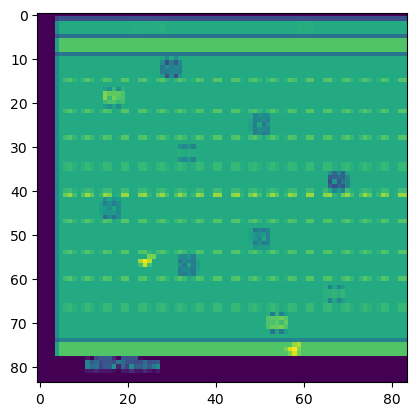

In [ ]:
plt.imshow(stacked_states[0,:,:,0])